# 01_PL_09_Project_network_partitioning [Work in progress]

## Import libraries

In [1]:
first_folder_path = "../"

In [134]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To create points (missing nodes) inside function network_partition()
from shapely.geometry import Point
# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src
else:
    import src

## Notebook config

In [10]:
# ----- ----- ----- City of analysis ----- ----- -----
city = 'guadalajara'

# ----- ----- ----- Input data directories ----- ----- ----- 
# Nodes and edges from notebook 01_PL_04_Combine_networks
nodes_dir = first_folder_path + f"data/output/shape/network_project/{city}/part02_step06_ntwsconsolidate/{city}_nodes_proj_net_consolidated5m.gpkg"
edges_dir = first_folder_path + f"data/output/shape/network_project/{city}/part02_step06_ntwsconsolidate/{city}_edges_proj_net_consolidated5m.gpkg"

# Polygons to create network partitions
polys_dir = first_folder_path + f"data/input/shape/Poligonos_Guadalajara/Poligonos.gpkg"

# ----- ----- ----- Projection to be used when needed ----- ----- ----- 
projected_crs = "EPSG:32613" #Guadalajara = 'EPSG:32613'

# ----- ----- ----- Output ----- ----- ----- 
output_dir = first_folder_path + f"data/output/shape/network_project_partitions/"
local_save = False

## Load data

In [14]:
# Load areas of interest
polys_gdf = gpd.read_file(polys_dir)
# Set crs
if polys_gdf.crs != projected_crs:
    polys_gdf = polys_gdf.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")

# Show
print(polys_gdf.crs)
print(polys_gdf.info())
polys_gdf

EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      3 non-null      object  
 1   geometry  3 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 176.0+ bytes
None


,name,geometry
0,miramar,"POLYGON ((659404.786 2283009.827, 660250.98 22..."
1,providencia,"POLYGON ((668619.092 2288755.457, 668816.754 2..."
2,colinas,"POLYGON ((665060.447 2289080.643, 665057.51 22..."


In [151]:
# Load nodes
cons_nodes = gpd.read_file(nodes_dir)
# Set crs
if cons_nodes.crs != projected_crs:
    cons_nodes = cons_nodes.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Filter for data of interest
cons_nodes = cons_nodes[['osmid','x','y','geometry']]

# Show
print(cons_nodes.crs)
print(cons_nodes.info())
cons_nodes.head(2)

EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125089 entries, 0 to 125088
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     125089 non-null  object  
 1   x         125089 non-null  float64 
 2   y         125089 non-null  float64 
 3   geometry  125089 non-null  geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 3.8+ MB
None


,osmid,x,y,geometry
0,67637870229114485,676378.709485,2.291145e+06,POINT (676378.709 2291144.858)
1,67640019229114922,676400.196372,2.291149e+06,POINT (676400.196 2291149.223)


In [152]:
mask = cons_nodes['osmid'].astype(str).str.startswith('[') & cons_nodes['osmid'].astype(str).str.endswith(']')
rows_with_lists_as_strings = cons_nodes[mask]
rows_with_lists_as_strings

,osmid,x,y,geometry
3,"[67636596229115605, 67636388229116380]",676364.926099,2.291160e+06,POINT (676364.926 2291159.926)
23,"[67546216228903067, 67546363228903968]",675462.903223,2.289035e+06,POINT (675462.903 2289035.181)
75,"[67638110229118667, 67637506229118442]",676378.086001,2.291186e+06,POINT (676378.086 2291185.551)
77,"[67425123228792493, 67424937228791839]",674250.306669,2.287922e+06,POINT (674250.307 2287921.667)
93,"[67392126228725236, 67392326228725929]",673922.268754,2.287256e+06,POINT (673922.269 2287255.834)
...,...,...,...,...
124036,"[71637744227421114, 71637975227421197]",716378.600312,2.274212e+06,POINT (716378.6 2274211.56)
124037,"[71638303227428121, 71638443227428270]",716383.734214,2.274282e+06,POINT (716383.734 2274281.959)
124038,"[71638986227435066, 71639309227435177]",716391.481548,2.274351e+06,POINT (716391.482 2274351.219)
124041,"[71644748227446635, 71644713227446196]",716447.311880,2.274464e+06,POINT (716447.312 2274464.158)


In [16]:
# Load edges
cons_edges = gpd.read_file(edges_dir)
# Set crs
if cons_edges.crs != projected_crs:
    cons_edges = cons_edges.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Filter for data of interest
cons_edges = cons_edges[['u','v','key','geometry']]

# Show
print(cons_edges.crs)
print(cons_edges.info())
cons_edges.head(2)

EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 197918 entries, 0 to 197917
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   u         197918 non-null  int64   
 1   v         197918 non-null  int64   
 2   key       197918 non-null  int64   
 3   geometry  197918 non-null  geometry
dtypes: geometry(1), int64(3)
memory usage: 6.0 MB
None


,u,v,key,geometry
0,67637870229114485,67640019229114922,0,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,67640019229114922,67640526229117504,0,"LINESTRING (676400.196 2291149.223, 676404.65 ..."


## Create partitions

In [143]:
def network_partition(aoi, nodes_gdf, edges_gdf, projected_crs):
    """
    Download OSMnx edges and nodes from DataBase according to GeoDataFrame boundary

    Arguments:
        aoi (geopandas.GeoDataFrame): GeoDataFrame polygon boundary.
        nodes_gdf (geopandas.GeoDataFrame): GeoDataFrame containing network nodes with 'osmid', 'x', 'y' and 'geometry' as columns.
        edges_gdf (geopandas.GeoDataFrame): GeoDataFrame containing network edges with 'u', 'v', 'key' and 'geometry' as columns.
        projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

    Returns:
        G (networkx.MultiDiGraph): Graph with edges and nodes within boundaries.
		nodes (geopandas.GeoDataFrame): GeoDataFrame for nodes within boundaries.
		edges (geopandas.GeoDataFrame): GeoDataFrame for edges within boundaries.
    """

    # --- Prepare area of interest
    aoi = aoi.to_crs(projected_crs)
    aoi = aoi.buffer(1).reset_index().rename(columns={0: "geometry"})
    aoi = aoi.set_geometry("geometry")
    aoi = aoi[['geometry']]
    
    # --- Prepare nodes
    nodes_gdf = nodes_gdf[['osmid','x','y','geometry']].copy()
    nodes_gdf['osmid'] = nodes_gdf['osmid'].astype('str')
    nodes_gdf = nodes_gdf.to_crs(projected_crs)

    # --- Prepare edges
    edges_gdf = edges_gdf[['u','v','key','geometry']].copy()
    edges_gdf['u'] = edges_gdf['u'].astype('str')
    edges_gdf['v'] = edges_gdf['v'].astype('str')
    edges_gdf['key'] = edges_gdf['key'].astype('str')
    edges_gdf = edges_gdf.to_crs(projected_crs)

    # --- Identify edges within area of interest (Spatial join)
    edges_in_aoi = gpd.sjoin(edges_gdf, aoi)
    edges_in_aoi = edges_in_aoi.drop(columns=['index_right'])
    
    # --- Identify the nodes that are used by those edges (Using edge's 'u' and 'v' values)
    nodes_id = edges_in_aoi.v.unique().tolist()
    u = edges_in_aoi.u.unique().tolist()
    nodes_id.extend(u)
    myset = set(nodes_id)
    nodes_id = list(myset)
    nodes_from_edges = nodes_gdf.loc[nodes_gdf.osmid.isin(nodes_id)].copy()

    # --- OUTPUT: Final format for edges
    # Drop duplicates
    edges_in_aoi.drop_duplicates(inplace=True)
    # Solve 'key' values
    edges = src.resolve_duplicates_indexes(edges_in_aoi, projected_crs)
    # Set indexes and set crs
    edges = edges.set_index(["u", "v", "key"])

    # --- Create any missing node that's not available to avoid problems when creating G
    # Preformat nodes - Drop duplicates
    nodes_from_edges.drop_duplicates(inplace=True)
    # Preformat nodes - Reset index
    nodes_from_edges.reset_index(inplace=True,drop=True)
    # Preformat edges - Reset index to be able to access 'u' and 'v'
    edges_tmp = edges.reset_index().copy()
    # Turn nodes into a dictionary that will be turned back into a gdf
    nodes_dict = nodes_from_edges.to_dict()
    
    # Edges 'u' that are missing from nodes 'osmid'
    from_osmid = list(set(edges_tmp['u'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))
    # For each missing 'u', append to nodes_dict the missing node
    for i in from_osmid:
        # Data
        row = edges_tmp.loc[(edges_tmp.u==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]
        # Register data
        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = first_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = first_coord[1]
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(first_coord)
            
    # Edges 'v' that are missing from nodes 'osmid'
    to_osmid = list(set(edges_tmp['v'].to_list()).difference(set(list(nodes_dict['osmid'].values()))))
    # For each missing 'v', append to nodes_dict the missing node
    for i in to_osmid:
        # Data
        row = edges_tmp.loc[(edges_tmp.v==i)].iloc[0]
        coords = [(coords) for coords in list(row['geometry'].coords)]
        first_coord, last_coord = [ coords[i] for i in (0, -1) ]
        # Register data
        nodes_dict['osmid'][len(nodes_dict['osmid'])] = i
        nodes_dict['x'][len(nodes_dict['x'])] = last_coord[0]
        nodes_dict['y'][len(nodes_dict['y'])] = last_coord[1]
        nodes_dict['geometry'][len(nodes_dict['geometry'])] = Point(last_coord)

    nodes_needing_creation = len(from_osmid) + len(to_osmid)
    print(f"Needed creation of {nodes_needing_creation} missing nodes.")
    if nodes_needing_creation>1:
        print("Missing nodes:")
        print(list(set(from_osmid+to_osmid)))
    
    # --- OUTPUT: Turn registered data back into gdf
    nodes = pd.DataFrame.from_dict(nodes_dict)
    nodes = gpd.GeoDataFrame(nodes, crs="EPSG:4326", geometry='geometry')
    nodes.set_index('osmid',inplace=True)

    # --- OUTPUT: Create G from final nodes and edges
    G = ox.graph_from_gdfs(nodes, edges)

    return G, nodes, edges

In [144]:
aoi = polys_gdf.loc[polys_gdf.name=='miramar'].copy()

G, nodes, edges = network_partition(aoi, cons_nodes, cons_edges, projected_crs)

Needed creation of 43 missing nodes.
Missing nodes:
['66005151228345931', '66004547228342819', '65989134228338646', '66009247228400956', '65963088228308213', '66005259228346488', '65996656228357879', '66003665228338822', '66008768228398159', '66025648228341662', '65998953228368383', '66014499228397043', '65992790228314574', '65996850228358767', '65999151228369284', '65948797228295249', '65972038228350470', '66004441228342235', '65973498228348998', '66003799228339379', '65999547228301031', '65972711228350357', '66007677228357735', '66025859228341633', '66021243228373533', '65957886228360329', '65989145228338794', '65957905228360298', '66021036228372587', '65992951228315493', '65976149228348946', '65962926228307361', '66013696228396462', '66017167228354993', '66008762228397876', '66007522228357007', '66007948228312345', '66008731228400821', '66007795228311593', '65973537228348963', '65998979228301108', '65976180228348928', '66017000228354285']


In [148]:
cons_nodes.loc[cons_nodes.osmid=='66005151228345931']

,osmid,x,y,geometry


In [149]:
cons_edges.loc[cons_edges.u=='66005151228345931']

,u,v,key,geometry
73856,66005151228345931,66004547228342819,0,"LINESTRING (660052.056 2283462.1, 660051.52 22..."
73857,66005151228345931,66014705228344516,0,"LINESTRING (660052.056 2283462.1, 660051.52 22..."


In [150]:
cons_edges.loc[cons_edges.v=='66005151228345931']

,u,v,key,geometry


In [137]:
nodes.head(2)

,x,y,geometry
osmid,,,
66039321228374187,660393.218659,2.283742e+06,POINT (660393.21866 2283741.87896)
66043571228373413,660435.715820,2.283734e+06,POINT (660435.71582 2283734.13361)


In [138]:
edges.head(2)

,,,geometry
u,v,key,
66039321228374187,66043571228373413,0,"LINESTRING (660393.219 2283741.879, 660435.716..."
66042318228368862,66043571228373413,0,"LINESTRING (660423.183 2283688.624, 660435.716..."


<Axes: >

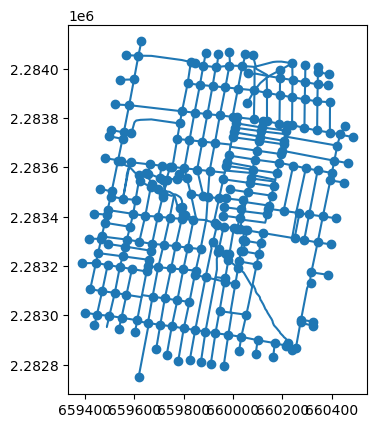

In [97]:
fig,ax = plt.subplots(1,1)

nodes_from_edges.plot(ax=ax,zorder=0)
edges_tmp.plot(ax=ax,zorder=0)

<Axes: >

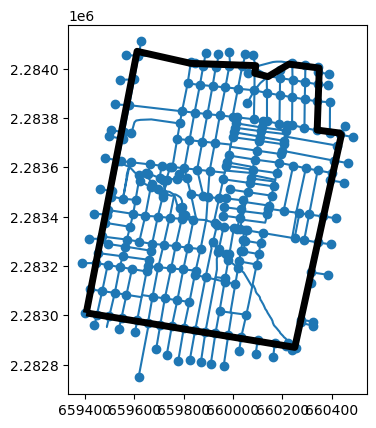

In [86]:
fig,ax = plt.subplots(1,1)

aoi.plot(ax=ax,zorder=1,linewidth=5,facecolor="none")
nodes_from_edges.plot(ax=ax,zorder=0)
edges_in_aoi.plot(ax=ax,zorder=0)

In [20]:
aoi

,name,geometry
0,miramar,"POLYGON ((659404.786 2283009.827, 660250.98 22..."
